### Primer approach modelo GAN 

__References:__

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

https://www.kaggle.com/code/dimitreoliveira/introduction-to-cyclegan-monet-paintings

In [14]:
import os, random, json, PIL, shutil, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
from tensorflow.keras import Model, losses, optimizers

/Users/lnogues/Desktop/other/project_monet_01/.conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/lnogues/Desktop/other/project_monet_01/.conda/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If 

In [15]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()


REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
AUTO = tf.data.experimental.AUTOTUNE

REPLICAS: 1


__Model Parameters__

In [16]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
EPOCHS = 50
BATCH_SIZE = 1

In [20]:
import glob
import os

# Directorio donde se encuentran las imágenes JPEG
jpeg_folder = 'data/monet_jpg'

# Patrón para buscar archivos JPEG en el directorio
jpeg_pattern = os.path.join(jpeg_folder, '*.jpg')  # Ajusta la extensión si es diferente

# Obtener lista de nombres de archivo JPEG
jpeg_files = glob.glob(jpeg_pattern)

# Función para contar el número de imágenes JPEG
def count_jpeg_images(file_list):
    return len(file_list)

# Contar el número de imágenes JPEG
n_photo_samples = count_jpeg_images(jpeg_files)

print(f'Photo image files: {n_photo_samples}')



Photo image files: 300


__Auxiliar Functions__

In [22]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image':      tf.io.FixedLenFeature([], tf.string),
        'target':     tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)

    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTO)
    photo_ds = photo_ds.prefetch(AUTO)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
    plt.show()
        
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        
        plt.subplot(121)
        plt.title("input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1
                

# Model functions
def downsample(filters, size, apply_instancenorm=True, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(L.Conv2D(filters, size, strides=strides, padding='same',
                        kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(L.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(L.Conv2DTranspose(filters, size, strides=strides, padding='same',
                                 kernel_initializer=initializer, use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(L.Dropout(0.5))

    result.add(L.ReLU())

    return result

In [23]:
display_samples(load_dataset(jpeg_files).batch(1), 4, 6)

2024-06-20 20:08:20.308956: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


DataLossError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} corrupted record at 0 (Is this even a TFRecord file?) [Op:IteratorGetNext]

<Figure size 1500x1000 with 0 Axes>

In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL

# Función para decodificar una imagen JPEG
def decode_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Asume imágenes en color (RGB)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Escalar píxeles al rango [0, 1]
    return image

# Directorio donde se encuentran las imágenes JPEG
jpeg_folder = 'data/monet_jpg'

# Patrón para buscar archivos JPEG en el directorio
jpeg_pattern = os.path.join(jpeg_folder, '*.jpg')  # Ajusta la extensión si es diferente

# Obtener lista de nombres de archivo JPEG
jpeg_files = glob.glob(jpeg_pattern)

# Función para crear un conjunto de datos TensorFlow a partir de los archivos JPEG
def create_dataset(file_paths, batch_size=1):
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = dataset.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset

# Crear conjunto de datos TensorFlow a partir de los archivos JPEG
photo_ds = create_dataset(jpeg_files)


In [29]:
from PIL import Image 

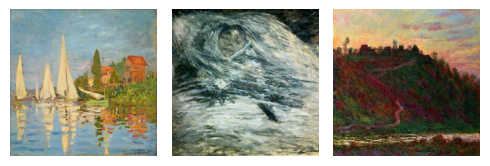

In [30]:
folder_path = 'data/monet_jpg'
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
fig, axes = plt.subplots(1, 3, figsize=(5, 3))
for i in range(3):
    img_path = os.path.join(folder_path, image_files[i])
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
plt.tight_layout()
plt.show()